<a href="https://colab.research.google.com/github/tlsdmswn01/NLP_Project---Audio/blob/main/%EC%9A%B4%EC%9C%A8%EC%9D%98%20%EC%9C%A0%EC%B0%BD%EC%84%B1%20%EC%A0%90%EC%88%98%20%EB%AA%A8%EB%8D%B8%EB%A7%81/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B_%EA%B5%AC%EC%B6%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/발음평가_데이터

/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/발음평가_데이터


In [ ]:
import os
import numpy as np
folder_path = "Shareddrives/자연어 처리 프로젝트/발음평가/발음평가_데이터"  # 파일이 들어 있는 폴더명
file_list = os.listdir(os.path.join('/content/drive', folder_path)) # 파일 목록명 불러오기

# 파일 목록 출력
print(file_list)

## 데이터 셋 만들기

### 오디오 파일과 라벨 데이터 짝 맞추기

In [ ]:
import pandas as pd

# 파일 경로와 확장자 명
wav = ".wav"  # 오디오 파일 확장자
json = ".json"  # 라벨링 파일 확장자


# 파일 이름이 같은 경우를 찾아서 데이터프레임으로 변환
data = []
for file in file_list:
    if file.endswith(wav):
        # 오디오 파일을 찾은 경우
        wav_file = file
        label_file = file.replace(wav, json)  # 라벨링 파일 찾기
        if label_file in file_list:
            # 라벨링 파일이 존재하는 경우
            data.append([wav_file, label_file])

# 데이터프레임 생성
df = pd.DataFrame(data, columns=["오디오 파일", "라벨링 파일"])

# 데이터프레임 출력
df.to_csv('/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/audio_label_dataset.csv')

In [ ]:
df.info()

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/audio_label_dataset.csv')

## 데이터 전처리

### MFCC 뽑아서 패딩까지

### 음성 데이터 길이 확인

100%|██████████| 8882/8882 [08:58<00:00, 16.48it/s]


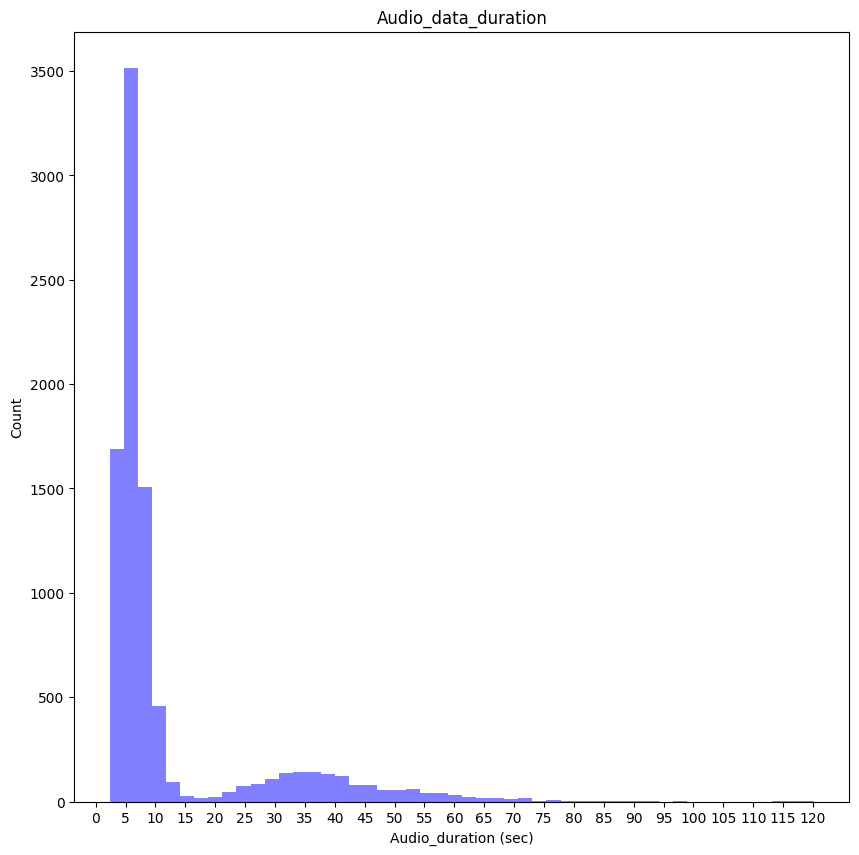

In [ ]:
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt

# 음성 데이터 길이를 저장할 리스트 생성
duration_list = []

for i in tqdm(range(len(df['오디오 파일']))):
    data1, sr = librosa.load(df['오디오 파일'][i], sr=16000)
    duration_in_seconds = librosa.get_duration(y=data1, sr=sr)
    duration_list.append(duration_in_seconds)

# 히스토그램 그리기
plt.figure(figsize=(10,10))
plt.hist(duration_list, bins=50, alpha=0.5, color='b')
plt.xticks(range(0, int(max(duration_list)) + 1, 5))
plt.xlabel('Audio_duration (sec)')
plt.ylabel('Count')
plt.title('Audio_data_duration')
plt.show()

In [ ]:
indices_to_remove = [i for i, duration in enumerate(duration_list) if duration >= 12]
df = df.drop(indices_to_remove)

In [ ]:
df.info()

In [ ]:
# 패딩함수 : 일정한 고정 길이를 설정 -> 긴 것은 자르고, 짧은 것은 늘리고
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

    - n_mfcc=100 : 기본값은 20,  한 음성에 대해 더 다양한 특징을 추출하고자 100으로 설정
    - n_fft=320: 일반적으로 자연어 처리에서는 음성을 20m의 크기를 기본으로 하고 있으며 16000Hz인 음성에서는 320에 해당하는 값
    - (16000 * 0.02 = 320) 즉, n_fft는 sr에 frame_length인 0.02를 곱한 값

    - hop_length = 160 : hop_length의 길이만큼 옆으로 가면서 데이터를 읽음
    - 10ms를 기본으로 하고 있어 16000Hz인 음성에서는 160에 해당
    - window_length가 0.025이고 frame_stride가 0.01이라고 하면 0.015초씩은 데이터를 겹치면서 읽는다고 생각

In [ ]:
# 각 wav 파일의 mfcc 뽑아내기
from sklearn.preprocessing import scale
def load_file_nopad(file_path):
    import librosa
    data,sr = librosa.load(file_path,sr=16000)
    mfcc = librosa.feature.mfcc(y=data, sr=16000,n_mfcc=100,n_fft=320,hop_length=160)
    return mfcc.shape[1]
    #mfcc = scale(mfcc, axis=1)


def load_file_pad(file_path):
    import librosa
    data,sr = librosa.load(file_path,sr=16000)
    mfcc = librosa.feature.mfcc(y=data, sr=16000,n_mfcc=100,n_fft=320,hop_length=160)
    #return mfcc.shape[1]
    #mfcc = scale(mfcc, axis=1)
    padded_mfcc600 = pad2d(mfcc, 600)
    padded_mfcc550 = pad2d(mfcc, 550)
    padded_mfcc500 = pad2d(mfcc, 500)
    return padded_mfcc600,padded_mfcc550,padded_mfcc500



In [ ]:
mfcc_list=[]
for i in df['오디오 파일']:
    audio_mfcc=load_file_nopad(i)
    mfcc_list.append(audio_mfcc)

mfcc_list600=[]
mfcc_list550=[]
mfcc_list500=[]
for i in df['오디오 파일']:
    audio_mfcc600,audio_mfcc550,audio_mfcc500=load_file_nopad(i)
    mfcc_list600.append(audio_mfcc600)
    mfcc_list550.append(audio_mfcc550)
    mfcc_list500.append(audio_mfcc500)

In [ ]:
plt.hist(mfcc_list, bins=50, alpha=0.5, color='b', edgecolor='black')
#plt.xticks(range(0, int(max(duration_list)) + 1, 5))

In [ ]:
print(np.mean(mfcc_list))
print(np.median(mfcc_list))

In [ ]:
print(mfcc_list[900].shape) # 각 행들은 다양한 값을 가지고 있는데 여기서 중요한 특징 100개씩만 뽑아옴

In [ ]:
mfcc_list[0].shape

In [ ]:
import pickle

with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/mfcc_list.pkl'","wb") as f:
    pickle.dump(mfcc_list, f) #shape 가 (100,600)

### 크로마그램 추출하기


- 패딩된것

In [ ]:
# 각 wav 파일의 chromagram 뽑아내기
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import scale
def load_chromagram(file_path):
    import librosa
    data,sr = librosa.load(file_path)
    chromagram= librosa.feature.chroma_stft(y=data,sr=16000,n_fft=320,hop_length=512)
    padded_chromagram600 = pad2d(chromagram, 600)
    padded_chromagram550 = pad2d(chromagram, 550)
    padded_chromagram500 = pad2d(chromagram, 500)
    return padded_chromagram600,padded_chromagram550,padded_chromagram500

chromagram_padded_list600=[]
chromagram_padded_list550=[]
chromagram_padded_list500=[]
for i in  tqdm(df['오디오 파일']):
    audio_chromagram600,audio_chromagram550,audio_chromagram500=load_chromagram(i)
    chromagram_padded_list600.append(audio_chromagram600)
    chromagram_padded_list550.append(audio_chromagram550)
    chromagram_padded_list500.append(audio_chromagram500)


In [ ]:
import pickle
with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/chromagram_list600.pkl'","wb") as f:
    pickle.dump(chromagram_padded_list600, f) #shape 가 (12,600)


import pickle
with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/chromagram_list550.pkl'","wb") as f:
    pickle.dump(chromagram_padded_list550, f) #shape 가 (12,550)


import pickle
with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/chromagram_list500.pkl'","wb") as f:
    pickle.dump(chromagram_padded_list500, f) #shape 가 (12,500)

- 패딩 안된 것

In [ ]:
# 각 wav 파일의 chromagram 뽑아내기
from sklearn.preprocessing import scale
def load_chromagram(file_path):
    import librosa
    data,sr = librosa.load(file_path)
    chromagram= librosa.feature.chroma_stft(y=data,sr=16000,n_fft=320,hop_length=512)
    return chromagram

chromagram_list=[]
for i in df['오디오 파일']:
    audio_chromagram=load_chromagram(i)
    chromagram_list.append(audio_chromagram)

In [ ]:
chromagram_list[10].shape

### json 파일에서 필요한 데이터만 가져오기

#### 발음평가, 운율평가, 능력치 데이터

In [ ]:
import json
arti_score_list=[]
pro_score_list=[]
ablility_list=[]

for i in tqdm(df['라벨링 파일']):
    json_file_name = i

    with open(json_file_name, 'r') as json_file:
        dataset_info = json.load(json_file)

    arti_score = dataset_info['itemScript']['rating']['articulationScore'] # 발음평가 점수
    pro_score = dataset_info['itemScript']['rating']['prosodyScore'] # 운율평가 점수
    ability=dataset_info['recorder']['ability'] # 능력평가 (High,Mid,Low)


    arti_score_list.append(arti_score)
    pro_score_list.append(pro_score)
    ablility_list.append(ability)


len(arti_score_list)
print('arti_score_list:',arti_score_list)
len(pro_score_list)
print('pro_score_list',pro_score_list)
len(ablility_list)
print('ablility_list',ablility_list)



In [ ]:
print(len(arti_score_list))

In [ ]:
# 문자를 숫자로
# 'Low' : 0, 'Mid':1, 'High':2
def num_encoding(i):

    if i=='LOW':
        i=0
    elif i=="MID":
        i=1
    else:
        i=2

    return i

ability_list=list(map(num_encoding, ablility_list))

In [ ]:
import pickle

with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/arti_score_list.pkl'","wb") as f:
    pickle.dump(arti_score_list, f)

In [ ]:
with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/pro_score_list.pkl'","wb") as f:
    pickle.dump(pro_score_list, f)

In [ ]:
with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/ability_list.pkl'","wb") as f:
    pickle.dump(ability_list, f)

## 데이터 시각화

In [ ]:
import pickle
with open("/content/drive/Shareddrives/자연어 처리 프로젝트/발음평가/pro_score_list.pkl'","rb") as f:
    pro_score_list=pickle.load(f)

In [ ]:
pro_ind=[]
pro_ind.append(pro_score_list.index(1.0))
pro_ind.append(pro_score_list.index(1.5))
pro_ind.append(pro_score_list.index(2.0))
pro_ind.append(pro_score_list.index(2.5))
pro_ind.append(pro_score_list.index(3.0))
pro_ind.append(pro_score_list.index(3.5))
pro_ind.append(pro_score_list.index(4.0))
pro_ind.append(pro_score_list.index(4.5))
pro_ind.append(pro_score_list.index(5.0))


In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

for i in pro_ind:
    amp_db=librosa.amplitude_to_db(np.abs(chromagram_list[i]),ref=np.max)
    librosa.display.specshow(amp_db,sr=16000,x_axis='time',y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pro_score:{}'.format(pro_score_list[i]))
    plt.tight_layout()
    plt.show()
    plt.savefig('크로마그램 이미지{}.png'.format(i))